https://archive.ics.uci.edu/ml/datasets/Energy+efficiency

X1 Relative Compactness  
X2 Surface Area  
X3 Wall Area  
X4 Roof Area  
X5 Overall Height  
X6 Orientation  
X7 Glazing Area  
X8 Glazing Area Distribution  
y1 Heating Load  
y2 Cooling Load  



Data Analysis Objective 1: Based on the 8 parameters, X1 - X8 collected about the building , need to find the equation for:   
y1 : Heating Load  
y2 : Cooling Load  

Data Analysis Objective 2: Based on the equation find the optimal parameters for the least:     
y1 : Heating Load  
y2 : Cooling Load  

This notebook is for DAO1 - modelling the heating load and cooling load.  

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

In [2]:
from sklearn.linear_model import LinearRegression, Lasso

In [3]:
from sklearn.neighbors import KNeighborsRegressor

In [4]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor

In [5]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, cross_val_score , cross_val_predict

In [6]:
from sklearn.metrics import  roc_auc_score, accuracy_score, classification_report, confusion_matrix, auc , roc_curve
from sklearn.model_selection import cross_val_predict, cross_val_score , train_test_split, cross_validate, KFold, GridSearchCV


In [7]:
import graphviz 
import sklearn.tree as tree

In [8]:
import statsmodels.formula.api as smf

In [9]:
energy_data = pd.read_excel("ENB2012_data.xlsx")

In [10]:
## Looking into file and their columns .

def file_details(filename):

    print(filename.head())
    print("\n")
    print(filename.info())
    print("\n")
    print(filename.isnull().sum())

In [7]:
file_details(energy_data)

     X1     X2     X3      X4   X5  X6   X7  X8     Y1     Y2
0  0.98  514.5  294.0  110.25  7.0   2  0.0   0  15.55  21.33
1  0.98  514.5  294.0  110.25  7.0   3  0.0   0  15.55  21.33
2  0.98  514.5  294.0  110.25  7.0   4  0.0   0  15.55  21.33
3  0.98  514.5  294.0  110.25  7.0   5  0.0   0  15.55  21.33
4  0.90  563.5  318.5  122.50  7.0   2  0.0   0  20.84  28.28


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 768 entries, 0 to 767
Data columns (total 10 columns):
X1    768 non-null float64
X2    768 non-null float64
X3    768 non-null float64
X4    768 non-null float64
X5    768 non-null float64
X6    768 non-null int64
X7    768 non-null float64
X8    768 non-null int64
Y1    768 non-null float64
Y2    768 non-null float64
dtypes: float64(8), int64(2)
memory usage: 60.1 KB
None


X1    0
X2    0
X3    0
X4    0
X5    0
X6    0
X7    0
X8    0
Y1    0
Y2    0
dtype: int64


In [11]:
energy_data.describe()

,X1,X2,X3,X4,X5,X6,X7,X8,Y1,Y2
count,768.000000,768.000000,768.000000,768.000000,768.00000,768.000000,768.000000,768.00000,768.000000,768.000000
mean,0.764167,671.708333,318.500000,176.604167,5.25000,3.500000,0.234375,2.81250,22.307195,24.587760
std,0.105777,88.086116,43.626481,45.165950,1.75114,1.118763,0.133221,1.55096,10.090204,9.513306
min,0.620000,514.500000,245.000000,110.250000,3.50000,2.000000,0.000000,0.00000,6.010000,10.900000
25%,0.682500,606.375000,294.000000,140.875000,3.50000,2.750000,0.100000,1.75000,12.992500,15.620000
50%,0.750000,673.750000,318.500000,183.750000,5.25000,3.500000,0.250000,3.00000,18.950000,22.080000
75%,0.830000,741.125000,343.000000,220.500000,7.00000,4.250000,0.400000,4.00000,31.667500,33.132500
max,0.980000,808.500000,416.500000,220.500000,7.00000,5.000000,0.400000,5.00000,43.100000,48.030000


In [12]:
energy_data.corr()[['Y1']]

,Y1
X1,0.622272
X2,-0.658120
X3,0.455671
X4,-0.861828
X5,0.889430
X6,-0.002587
X7,0.269842
X8,0.087368
Y1,1.000000
Y2,0.975862


In [13]:
energy_data.corr()[['Y2']]

,Y2
X1,0.634339
X2,-0.672999
X3,0.427117
X4,-0.862547
X5,0.895785
X6,0.014290
X7,0.207505
X8,0.050525
Y1,0.975862
Y2,1.000000


In [14]:
## Note down rmse for various models 
r2_y1 = {}
r2_y2 = {}

In [11]:
def perform_reg(model,X_train, X_test, y_train,y_test, reg):
    model.fit(X_train,y_train)
    pred_train = model.predict(X_train)
    pred_test = model.predict(X_test)
    residue = y_test - pred_test

    print("\n RMSE :{}".format(np.sqrt(mean_squared_error(y_test,pred_test))))
    print("\n R2 :{}".format(r2_score(y_test,pred_test)))
    
    if reg == 'Ln':
        print("\n Coefficients {}".format(model.coef_))
        print("\n Intercept :{}".format(model.intercept_))
    if reg == 'Dt':
        print("\nmax depth :{}".format(model.tree_.max_depth))


## Plot the predicted Vs actual values for training data 
    plt.figure(figsize = (8,6))
    plt.scatter(y_train, pred_train)
    plt.xlabel("actual")
    plt.ylabel('predicted')
    plt.title("Train data Vs Predicted")
    plt.show()

## Plot the predicted Vs actual values 
    plt.figure(figsize = (8,6))
    plt.scatter(y_test, pred_test)
    plt.title("Actual and Predicted values for Test data ")
    plt.show()

## Plot Residue   
    plt.figure(figsize = (8,6))
    plt.scatter(y_test, residue)
    plt.title("Residue Vs actual  ")
    #plt.show()
## Plot histogram of actual and predicted values
    plt.figure(figsize = (8,6))
    plt.hist(y_test, label = 'actual')
    plt.hist(pred_test, label = 'predicted')
    plt.legend()
    plt.show
    
    ## Plot Variable importance for decision tree , random forest
    if (reg == 'Dt') | (reg == 'rf') | (reg == 'gbm'):
        cols = X_train.columns.tolist()
        plt.figure(figsize = (8,5))
        plt.bar(cols, model.feature_importances_)
        plt.xticks(rotation = 90)

    return 



 X_train shape :(614, 4)

 X_test shape :(154, 4)

 y_train shape :(614,)

 y_test shape :(154,)

 RMSE :3.401854121229725

 R2 :0.8848377579027356


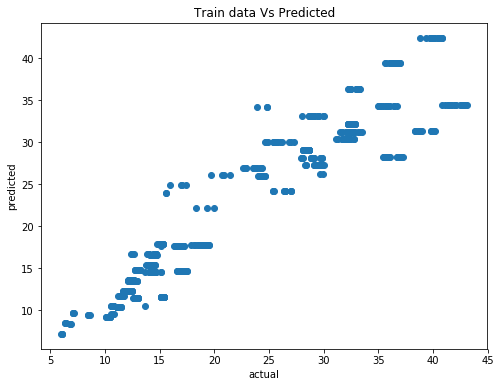

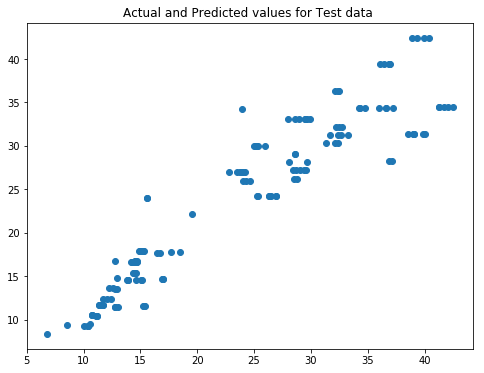

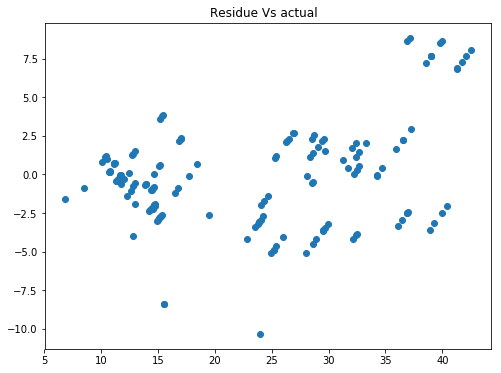

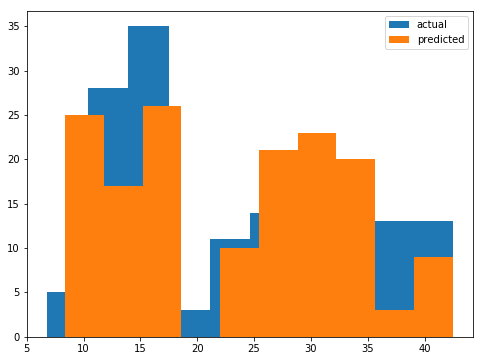

In [16]:
predictors = energy_data[['X1','X2','X3','X7']]
target = energy_data['Y1']
##
Ln = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
##

print("\n X_train shape :{}".format(X_train.shape))
print("\n X_test shape :{}".format(X_test.shape))
print("\n y_train shape :{}".format(y_train.shape))
print("\n y_test shape :{}".format(y_test.shape))
##
perform_reg(Ln, X_train, X_test, y_train,y_test, 'ln')


In [17]:
est = smf.ols(formula='Y1 ~ X1 + X2 +X3 + X7 ', data = energy_data).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Y1   R-squared:                       0.898
Model:                            OLS   Adj. R-squared:                  0.898
Method:                 Least Squares   F-statistic:                     1688.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:13:48   Log-Likelihood:                -1986.1
No. Observations:                 768   AIC:                             3982.
Df Residuals:                     763   BIC:                             4006.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    261.7508     13.698     19.109      0.000     234.861     288.640
X1          -145.9434      8.691    -16.793      0.000    -163.004    -128.883
X2            -0.2625      0.010    -25.194      0.000      -0.283      -0.242
X3             0.1369      0.003     50.162      0.000       0.132       0.142
X7            20.4380      0.874     23.393      0.000      18.723      22.153
==============================================================================
Omnibus:                       71.314   Durbin-Watson:                   0.701
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              114.775
Skew:                           0.646   Prob(JB):                     1.19e-25
Kurtosis:                       4.384   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


 X_train shape :(614, 4)

 X_test shape :(154, 4)

 y_train shape :(614,)

 y_test shape :(154,)

 RMSE :0.1435253951040439

 R2 :0.9018293559752373


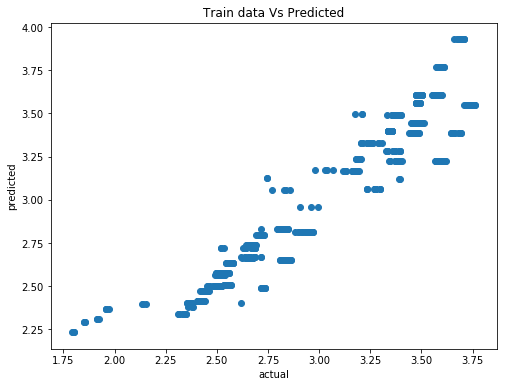

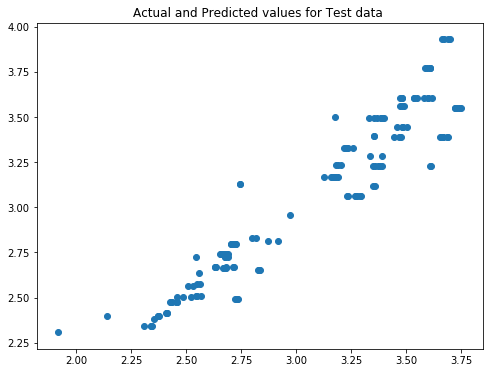

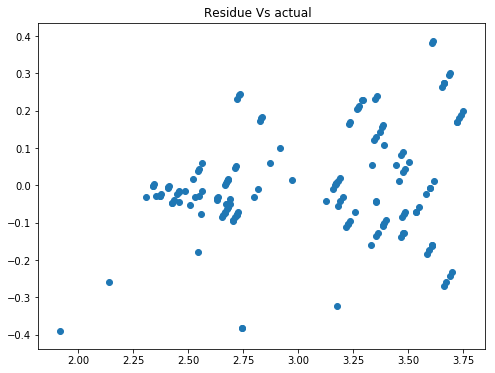

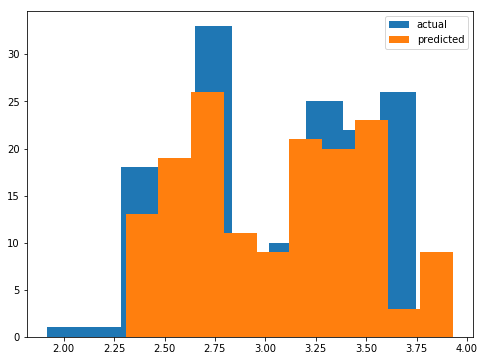

In [18]:
## Log transformation of target variable Y1 
predictors = energy_data[['X1','X2','X3','X7']]
target = np.log(energy_data['Y1'])
##
Ln = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
##

print("\n X_train shape :{}".format(X_train.shape))
print("\n X_test shape :{}".format(X_test.shape))
print("\n y_train shape :{}".format(y_train.shape))
print("\n y_test shape :{}".format(y_test.shape))
##
perform_reg(Ln, X_train, X_test, y_train,y_test,'ln')

Log transformation of Y1 improves the R2 score  to 0.90.

In [15]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X2','X3','X7']]
target = np.log(energy_data['Y1'])
##
Ln = LinearRegression()
cross_val_score(Ln, predictors , target, cv = kf).mean()

0.90083903297736045

In [16]:
r2_y1['Linear Regression'] = 0.901

In [20]:
## Coefficient and P value for the predictors with log transformed target Y1
energy_data['log_Y1'] = np.log(energy_data['Y1'])
est = smf.ols(formula='log_Y1 ~ X1 + X2 +X3 + X7 + C(X8) ', data = energy_data).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_Y1   R-squared:                       0.924
Model:                            OLS   Adj. R-squared:                  0.923
Method:                 Least Squares   F-statistic:                     1029.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:14:10   Log-Likelihood:                 471.16
No. Observations:                 768   AIC:                            -922.3
Df Residuals:                     758   BIC:                            -875.9
Df Model:                           9                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     10.5544      0.561     18.826      0.000       9.454      11.655
C(X8)[T.1]     0.3269      0.024     13.530      0.000       0.279       0.374
C(X8)[T.2]     0.3221      0.024     13.333      0.000       0.275       0.370
C(X8)[T.3]     0.3096      0.024     12.812      0.000       0.262       0.357
C(X8)[T.4]     0.3192      0.024     13.210      0.000       0.272       0.367
C(X8)[T.5]     0.3082      0.024     12.757      0.000       0.261       0.356
X1            -4.6256      0.356    -13.009      0.000      -5.324      -3.928
X2            -0.0098      0.000    -22.927      0.000      -0.011      -0.009
X3             0.0065      0.000     57.875      0.000       0.006       0.007
X7             0.7892      0.040     19.667      0.000       0.710       0.868
==============================================================================
Omnibus:                       71.005   Durbin-Watson:                   0.694
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               88.680
Skew:                           0.813   Prob(JB):                     5.54e-20
Kurtosis:                       3.353   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [21]:
## Predicting Cooling load Y2
est = smf.ols(formula='Y2 ~ X1 + X2 +X3 + X7 ', data = energy_data).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                     Y2   R-squared:                       0.868
Model:                            OLS   Adj. R-squared:                  0.867
Method:                 Least Squares   F-statistic:                     1250.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:14:20   Log-Likelihood:                -2042.8
No. Observations:                 768   AIC:                             4096.
Df Residuals:                     763   BIC:                             4119.
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    279.9703     14.746     18.986      0.000     251.022     308.918
X1          -154.1746      9.356    -16.478      0.000    -172.541    -135.808
X2            -0.2682      0.011    -23.914      0.000      -0.290      -0.246
X3             0.1228      0.003     41.811      0.000       0.117       0.129
X7            14.8180      0.941     15.754      0.000      12.972      16.664
==============================================================================
Omnibus:                      191.012   Durbin-Watson:                   1.073
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              436.277
Skew:                           1.330   Prob(JB):                     1.84e-95
Kurtosis:                       5.561   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""


 X_train shape :(614, 4)

 X_test shape :(154, 4)

 y_train shape :(614,)

 y_test shape :(154,)

 RMSE :0.13555891522684327

 R2 :0.8787916618561731


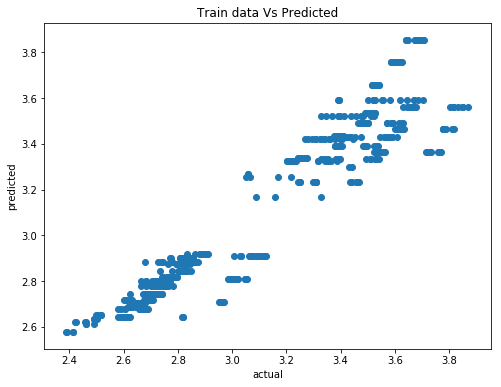

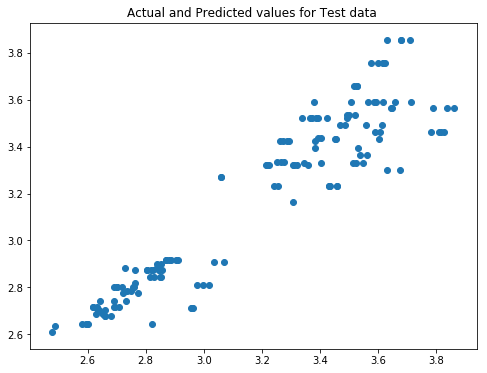

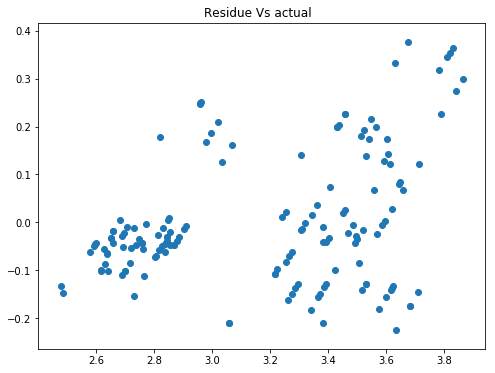

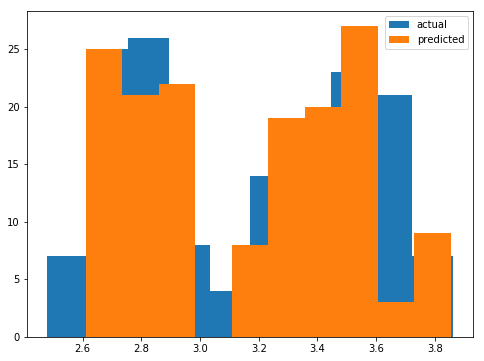

In [22]:
predictors = energy_data[['X1','X2','X3','X7']]
target = np.log(energy_data['Y2'])
##
Ln = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
##

print("\n X_train shape :{}".format(X_train.shape))
print("\n X_test shape :{}".format(X_test.shape))
print("\n y_train shape :{}".format(y_train.shape))
print("\n y_test shape :{}".format(y_test.shape))
##
perform_reg(Ln, X_train, X_test, y_train,y_test,'ln')


In [17]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X2','X3','X7']]
target = np.log(energy_data['Y2'])
##
Ln = LinearRegression()
cross_val_score(Ln, predictors , target, cv = kf).mean()

0.88942352471103914

In [18]:
r2_y2['Linear regression'] = 0.8895

In [24]:
## Coefficient and P value for the predictors with log transformed target Y1
energy_data['log_Y2'] = np.log(energy_data['Y2'])
est = smf.ols(formula='log_Y2 ~ X1 + X2 +X3 + X7 ', data = energy_data).fit()
est.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                 log_Y2   R-squared:                       0.892
Model:                            OLS   Adj. R-squared:                  0.892
Method:                 Least Squares   F-statistic:                     1580.
Date:                Wed, 10 Jun 2020   Prob (F-statistic):               0.00
Time:                        19:14:39   Log-Likelihood:                 484.13
No. Observations:                 768   AIC:                            -958.3
Df Residuals:                     763   BIC:                            -935.0
Df Model:                           4                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     11.7856      0.549     21.460      0.000      10.707      12.864
X1            -5.1108      0.348    -14.667      0.000      -5.795      -4.427
X2            -0.0097      0.000    -23.244      0.000      -0.011      -0.009
X3             0.0051      0.000     46.416      0.000       0.005       0.005
X7             0.6417      0.035     18.317      0.000       0.573       0.710
==============================================================================
Omnibus:                       93.569   Durbin-Watson:                   0.873
Prob(Omnibus):                  0.000   Jarque-Bera (JB):              126.201
Skew:                           0.975   Prob(JB):                     3.94e-28
Kurtosis:                       3.376   Cond. No.                     1.04e+05
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.04e+05. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Equation for Heating Load Y1 :=  
exp(10.5544 -4.6256*X1 - 0.0098*X2 + 0.0065*X3 + 0.7898*X7 +0.38629*X8(If Value == 1) + 0.3221*X8(If Value ==2) +0.3096*X8(If value ==3) + 0.3192*X8(If value == 4) + 0.3082*X8(If value == 5)  

Equation for Cooling Load Y2 :-  
exp(11.7856 -5.1108*X1 - 0.0097*X2 + 0.0051*X3 + 0.641*X7)  


 X_train shape :(614, 4)

 X_test shape :(154, 4)

 y_train shape :(614,)

 y_test shape :(154,)

 RMSE :0.1444090781249216

 R2 :0.9006167650528067


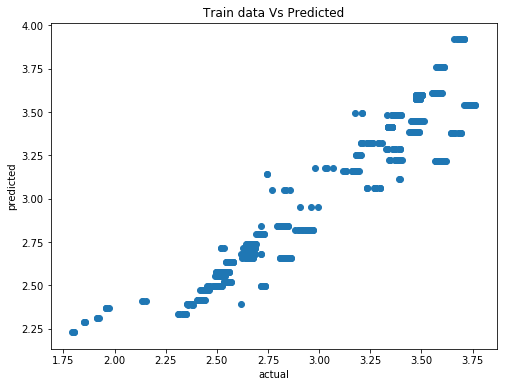

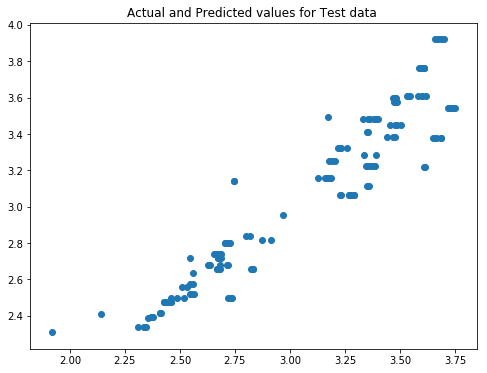


 RMSE :0.15967825329824975

 R2 :0.8784889749706057


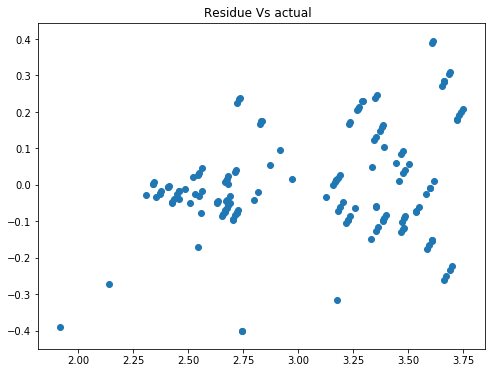

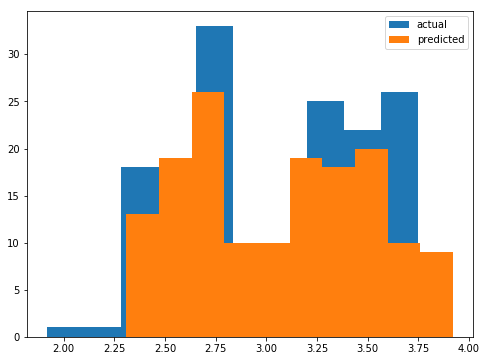

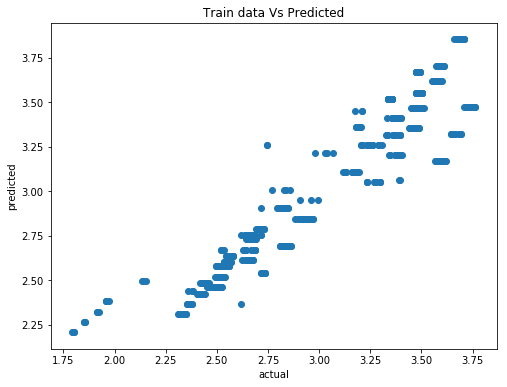

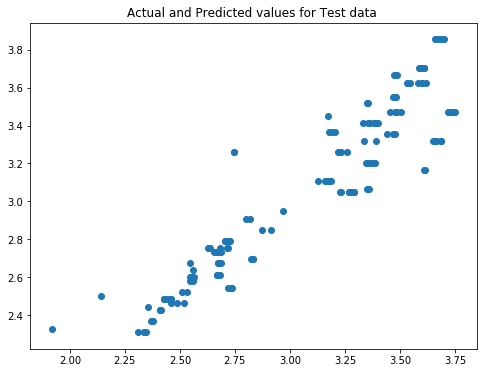


 RMSE :0.1722194249159364

 R2 :0.8586524102697023


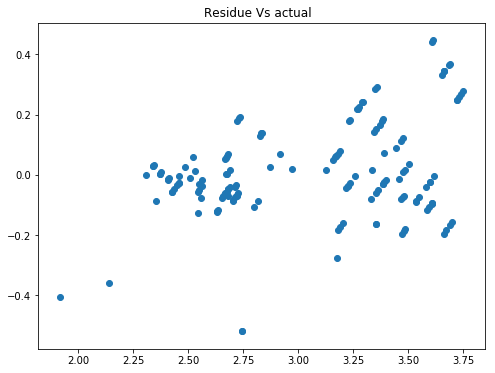

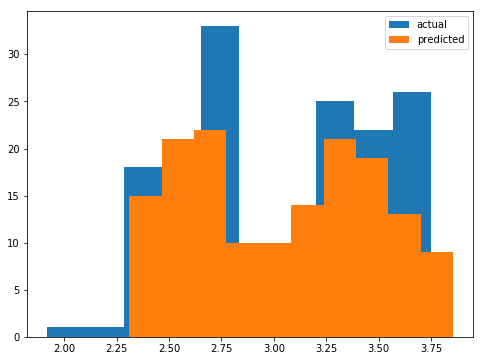

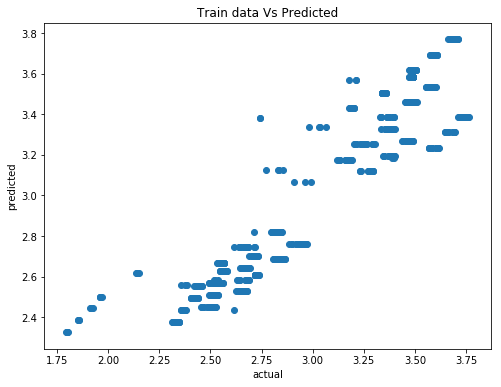

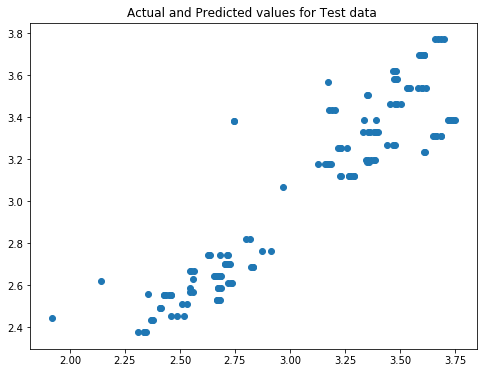


 RMSE :0.20820469577364661

 R2 :0.7934119585645925


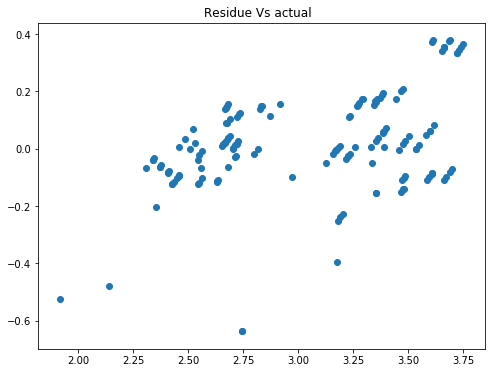

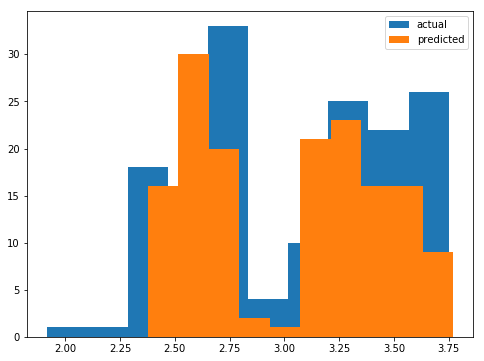

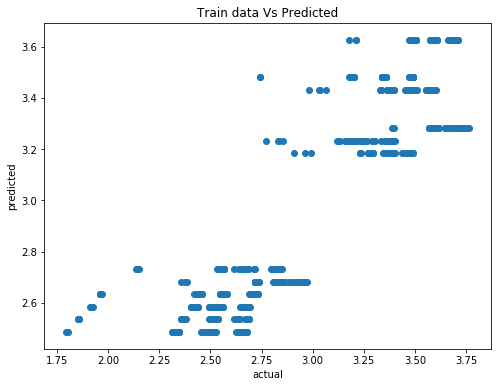

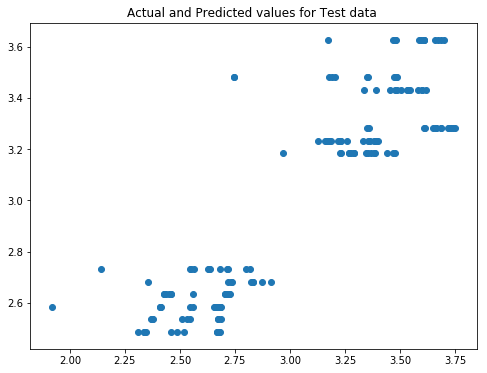

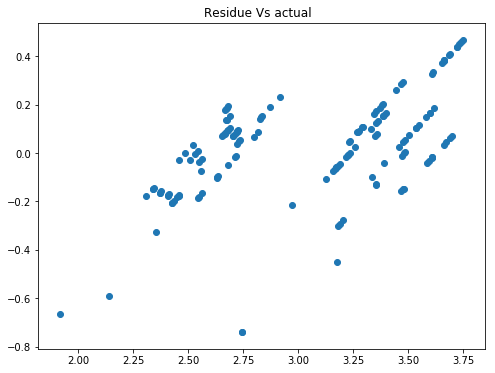

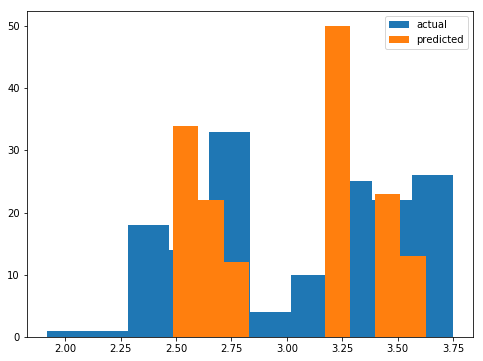

In [25]:
## Check performance improvement with Lasso 
predictors = energy_data[['X1','X2','X3','X7']]
target = np.log(energy_data['Y1'])
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
##

print("\n X_train shape :{}".format(X_train.shape))
print("\n X_test shape :{}".format(X_test.shape))
print("\n y_train shape :{}".format(y_train.shape))
print("\n y_test shape :{}".format(y_test.shape))
##
alphas = [0.0001,0.001,0.01,1]
coefs = {}
for a in alphas:
    Lasso_reg = Lasso(alpha = a)
    coefs[a] = perform_reg(Lasso_reg,X_train, X_test, y_train,y_test,'ln')



There is no performance improvement with Lasso.


 X_train shape :(614, 4)

 X_test shape :(154, 4)

 y_train shape :(614,)

 y_test shape :(154,)

 RMSE :0.14352539510404408

 R2 :0.9018293559752371


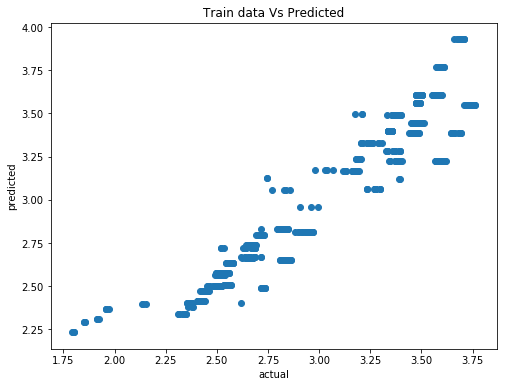

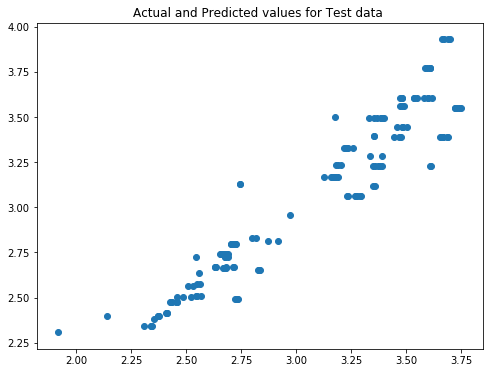

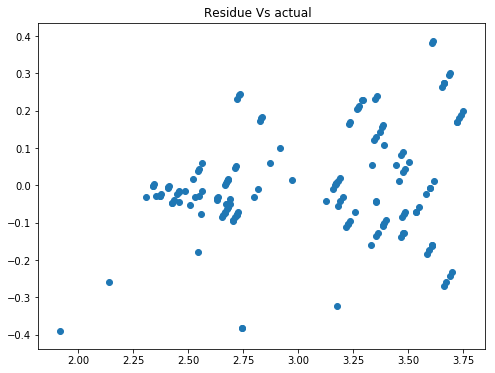

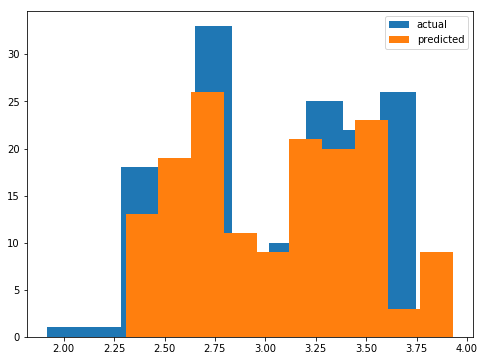

In [26]:
## Effect of scaling on Linear Regression

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
##
scaled_data = scaler.fit_transform(energy_data[['X1','X2','X3','X7']])
target = np.log(energy_data['Y1'])
#
Ln = LinearRegression()

X_train, X_test, y_train, y_test = train_test_split(scaled_data, target, random_state = 1, test_size = 0.2)
##

print("\n X_train shape :{}".format(X_train.shape))
print("\n X_test shape :{}".format(X_test.shape))
print("\n y_train shape :{}".format(y_train.shape))
print("\n y_test shape :{}".format(y_test.shape))
##
perform_reg(Ln, X_train, X_test, y_train,y_test, 'ln')
                                               

Scaling the variables does not improve the RMSE.

Non parametric modelling of heating and cooling load.  


 X_train : (614, 2)

 X_test : (154, 2)

 y_train : (614,)

 y_test : (154,)

 RMSE :1.6720181817665745

 R2 :0.9721797690739579

max depth :4


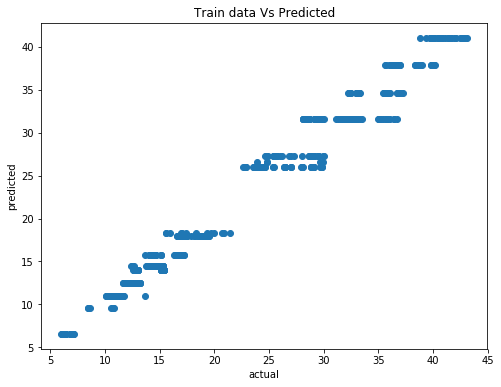

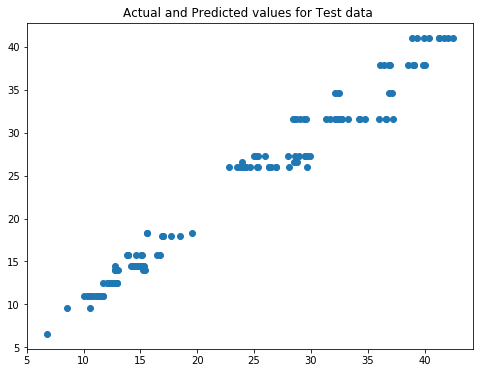

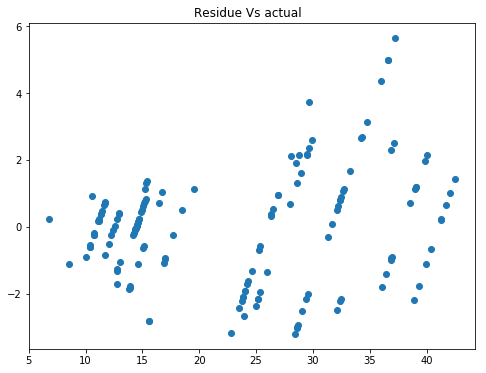

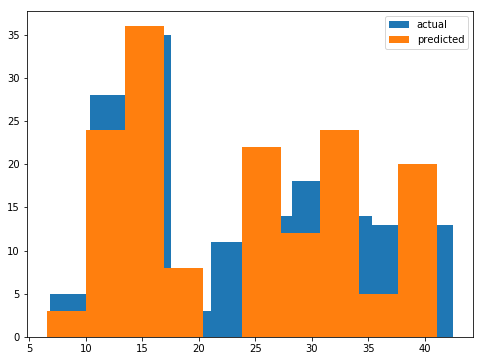

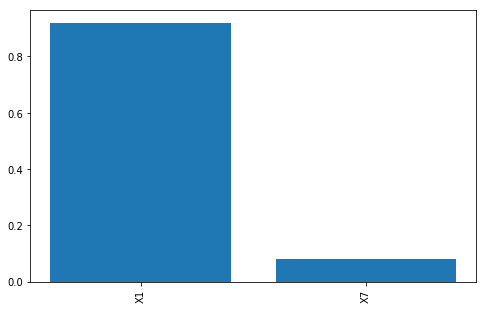

In [27]:
predictors = energy_data[['X1','X7']]
target = energy_data['Y1']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))
##

dt = DecisionTreeRegressor(random_state = 2, max_depth = 4)

perform_reg(dt, X_train, X_test, y_train,y_test, 'Dt')

In [19]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X7']]
target = energy_data['Y1']
##
dt = DecisionTreeRegressor(random_state = 2, max_depth = 4)
cross_val_score(dt, predictors , target, cv = kf).mean()

0.97469952609070221

In [20]:
r2_y1['Decision Trees'] = 0.975

In [29]:
dt.fit(X_train, y_train)
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("heating load prediction tree ")

'heating load prediction tree .pdf'

With Decision Trees modelling, with two variables X1 and X7 we are able to reduce the RMSE to 1.67 and R2 increased to  0.97.


 X_train : (614, 2)

 X_test : (154, 2)

 y_train : (614,)

 y_test : (154,)

 RMSE :1.5416062796444356

 R2 :0.9763502975707186


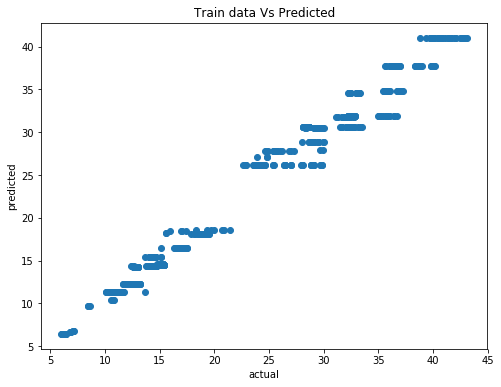

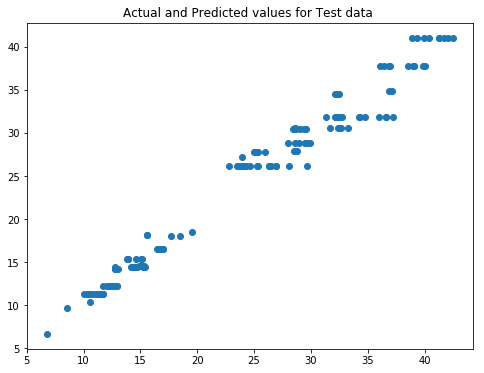

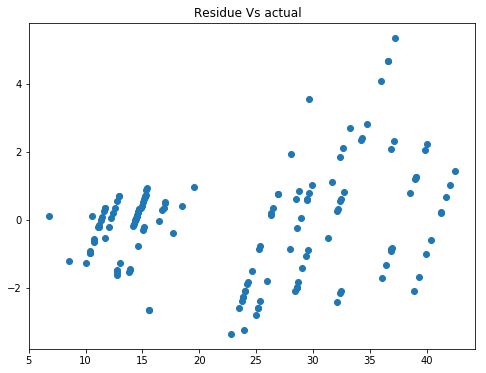

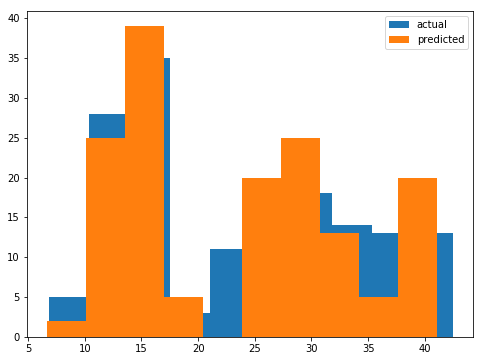

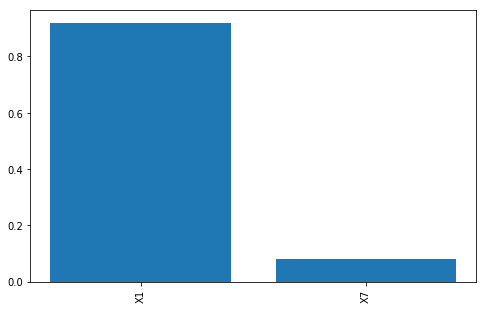

In [30]:
## RandomForest Regression.
predictors = energy_data[['X1','X7']]
target = energy_data['Y1']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))

rf = RandomForestRegressor(n_estimators = 100, max_depth = 4)
rf.fit(X_train,y_train)
ft = rf.feature_importances_
perform_reg(rf, X_train, X_test, y_train,y_test, 'rf')

In [21]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X7']]
target = energy_data['Y1']
##
rf = RandomForestRegressor(n_estimators = 100, max_depth = 4)
cross_val_score(rf, predictors , target, cv = kf).mean()

0.97816039380316566

In [22]:
r2_y1['Random Forest'] = 0.978

Random Forest Regression performs similarly to Decision Trees Regression.


 X_train : (614, 4)

 X_test : (154, 4)

 y_train : (614,)

 y_test : (154,)

 RMSE :0.5342503639496431

 R2 :0.9971596726706269


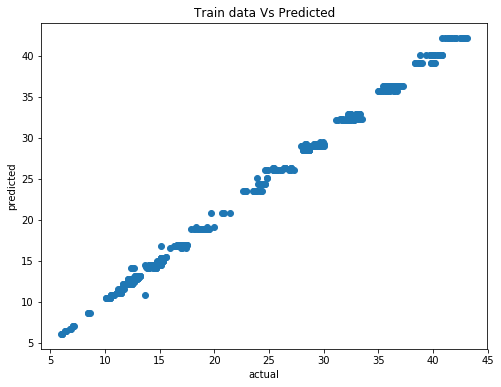

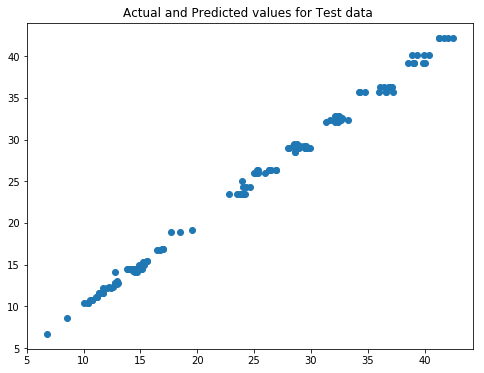

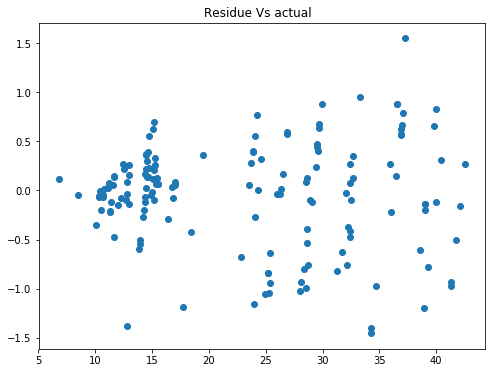

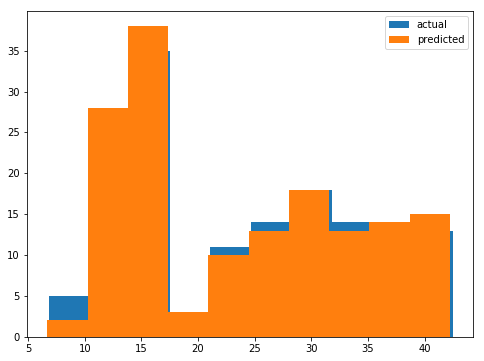

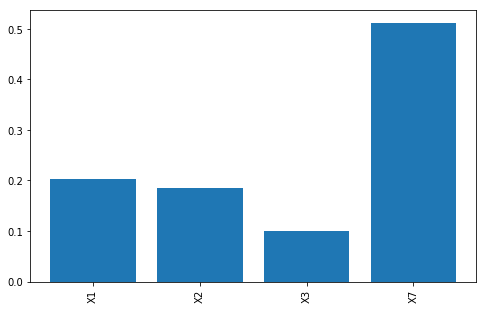

In [23]:
## Gradient Boosting Regression.
predictors = energy_data[['X1','X2','X3','X7']]
target = energy_data['Y1']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))

gbm = GradientBoostingRegressor(n_estimators = 500, max_depth = 2)
perform_reg(gbm, X_train, X_test, y_train,y_test, 'gbm')

In [23]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X2','X3','X7']]
target = energy_data['Y1']
##
gbm = GradientBoostingRegressor(n_estimators = 500, max_depth = 2)
cross_val_score(gbm, predictors , target, cv = kf).mean()

0.99753257760519032

In [24]:
r2_y1['GBM'] = 0.998


 X_train : (614, 2)

 X_test : (154, 2)

 y_train : (614,)

 y_test : (154,)

 RMSE :1.377533099420845

 R2 :0.9811164855483491


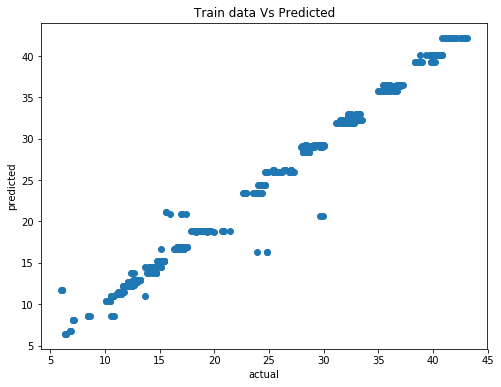

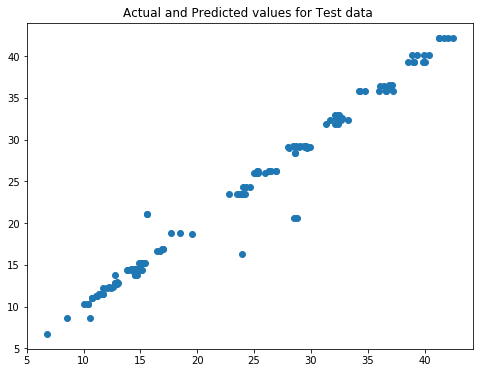

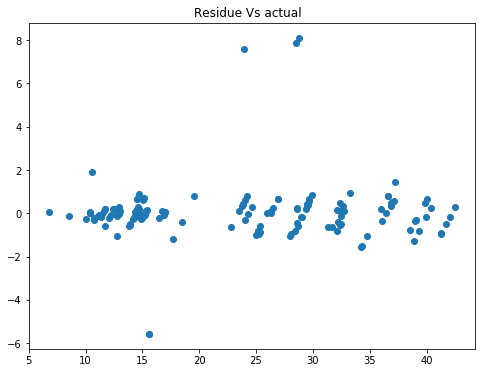

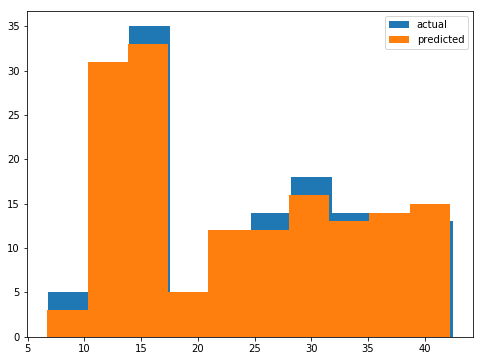

In [32]:
## KNN Regressor .
predictors = energy_data[['X1','X7']]
target = energy_data['Y1']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))
knn = KNeighborsRegressor(n_neighbors = 10)
perform_reg(knn, X_train, X_test, y_train,y_test, 'knn')


In [25]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X7']]
target = energy_data['Y1']
##
knn = KNeighborsRegressor(n_neighbors = 10)
cross_val_score(knn, predictors , target, cv = kf).mean()

0.98451958383781868

In [26]:
r2_y1['KNN'] = 0.9845

GBM Regressor gives the least RMSE among the different models. Variables X1 ,X2, X3 and  X7 seem to be the most important among the given variables as seen for most of the models.    

Predicting Cooling Load with Decision Trees  


 X_train : (614, 2)

 X_test : (154, 2)

 y_train : (614,)

 y_test : (154,)

 RMSE :2.212827107547847

 R2 :0.947396911718654

max depth :4


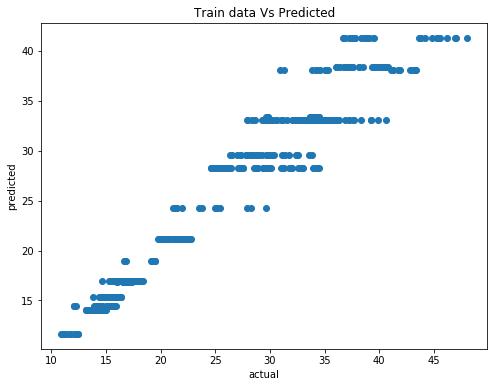

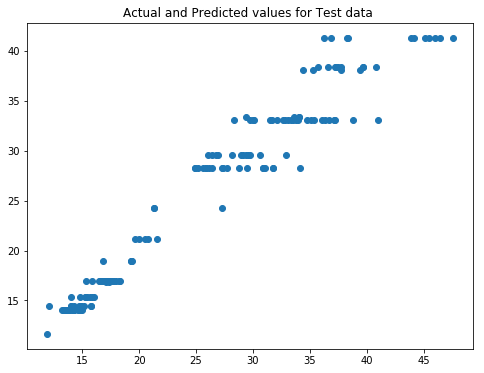

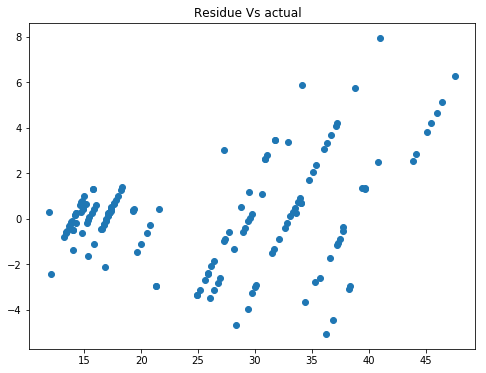

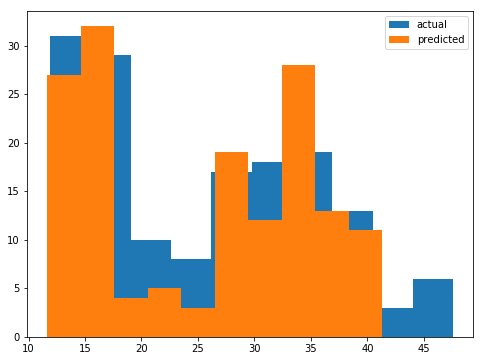

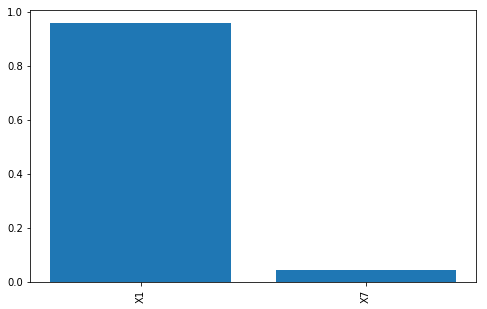

In [38]:
predictors = energy_data[['X1','X7']]
target = energy_data['Y2']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))
##

dt = DecisionTreeRegressor(random_state = 2,max_depth = 4)

perform_reg(dt, X_train, X_test, y_train,y_test, 'Dt')

In [39]:
dt.fit(X_train, y_train)
dot_data = tree.export_graphviz(dt, out_file=None) 
graph = graphviz.Source(dot_data) 
graph.render("cooling load prediction tree ")

'cooling load prediction tree .pdf'

In [27]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X7']]
target = energy_data['Y2']
##
dt = DecisionTreeRegressor(random_state = 2, max_depth = 4)
cross_val_score(dt, predictors , target, cv = kf).mean()

0.94783339781366216

In [28]:
r2_y2['Decision Trees'] = 0.948

For Cooling load too , Decision Trees have improved the R2 to 0.95 and with  two variables X1 and X7 are able to reduce the RMSE to 2.2.  


 X_train : (614, 2)

 X_test : (154, 2)

 y_train : (614,)

 y_test : (154,)

 RMSE :2.0750794408379325

 R2 :0.9537421193630932


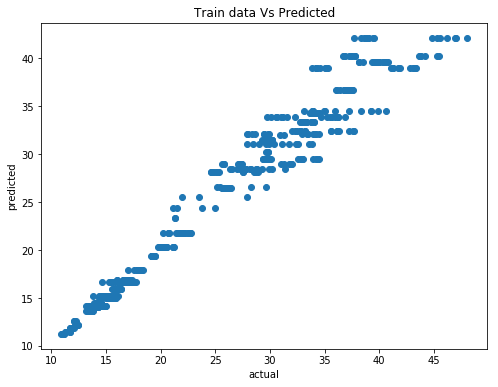

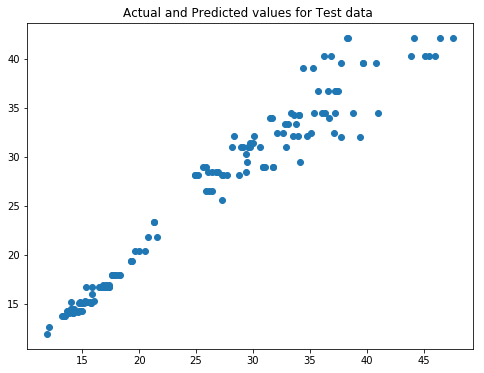

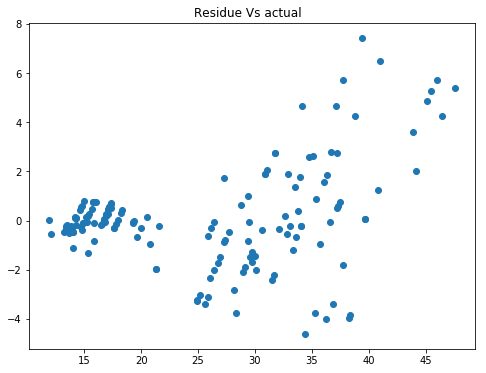

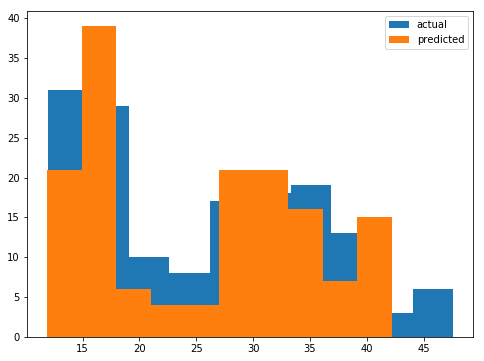

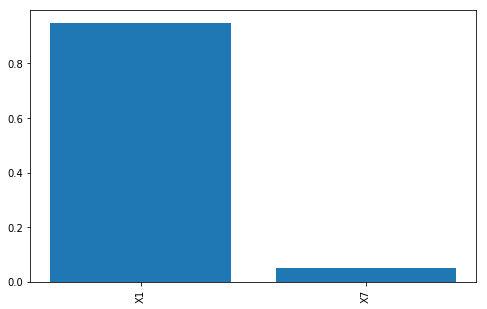

In [36]:
## RandomForest Regression.
predictors = energy_data[['X1','X7']]
target = energy_data['Y2']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))

rf = RandomForestRegressor(n_estimators = 100,max_depth = 5)
rf.fit(X_train,y_train)
ft = rf.feature_importances_
perform_reg(rf, X_train, X_test, y_train,y_test, 'rf')

In [29]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X7']]
target = energy_data['Y2']
##
rf = RandomForestRegressor(n_estimators = 100,max_depth = 5)
cross_val_score(rf, predictors , target, cv = kf).mean()

0.96257306927366082

In [30]:
r2_y2['Random Forest'] = 0.963

Similar performance of Random Forest Regression as that of Decision Trees in predicting Cooling Load Y2.


 X_train : (614, 5)

 X_test : (154, 5)

 y_train : (614,)

 y_test : (154,)

 RMSE :1.8428148218709648

 R2 :0.9635179134539857


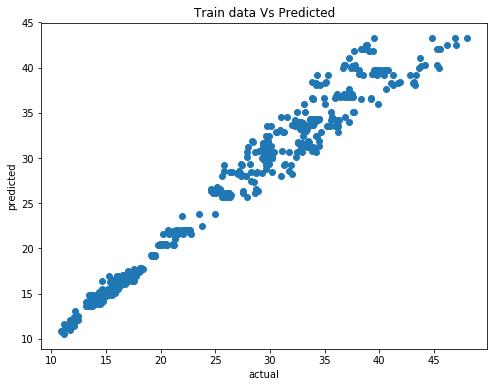

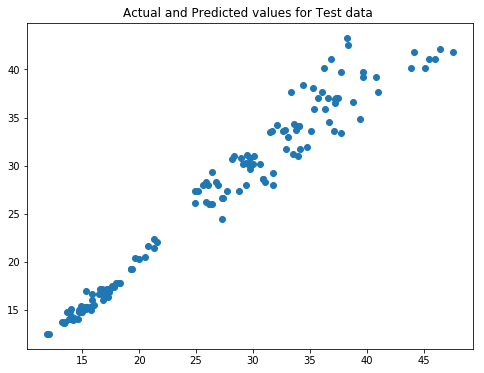

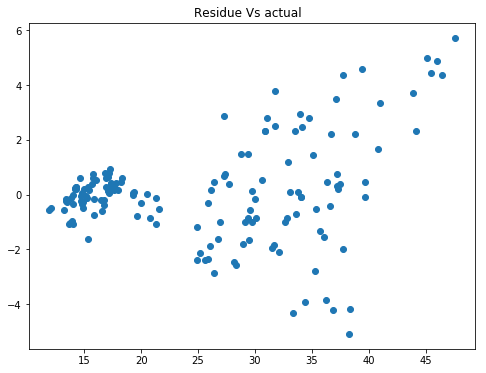

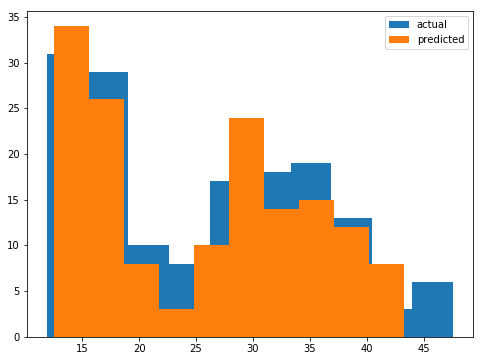

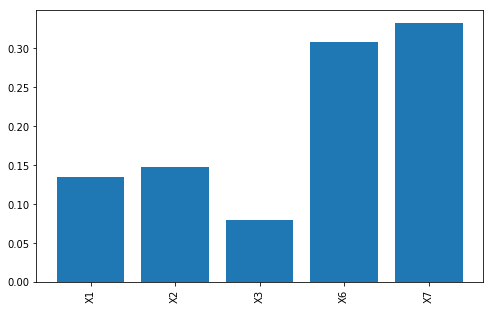

In [31]:
## Gradient Boosting Regression.
predictors = energy_data[['X1','X2','X3','X6','X7']]
target = energy_data['Y2']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))

gbm = GradientBoostingRegressor(n_estimators = 500 , random_state = 3, max_depth = 2)
perform_reg(gbm, X_train, X_test, y_train,y_test, 'gbm')

In [35]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X2','X3','X6','X7']]
target = energy_data['Y2']
##
gbm = GradientBoostingRegressor(n_estimators = 500 , random_state = 3, max_depth = 2)
cross_val_score(gbm, predictors , target, cv = kf).mean()

0.96981044931637683

In [36]:
r2_y2['GBM'] = 0.969


 X_train : (614, 2)

 X_test : (154, 2)

 y_train : (614,)

 y_test : (154,)

 RMSE :2.4831307192395586

 R2 :0.9337607446799859


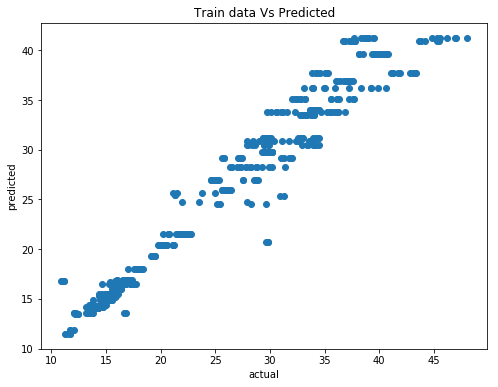

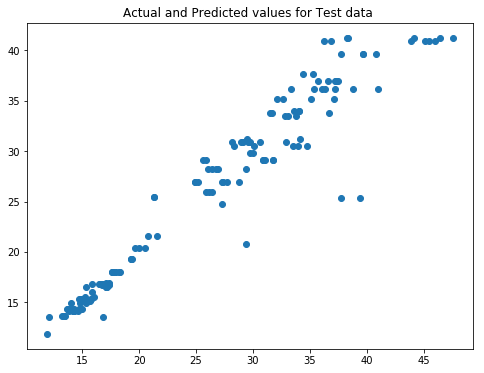

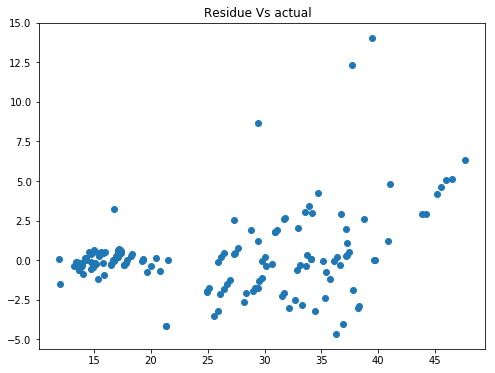

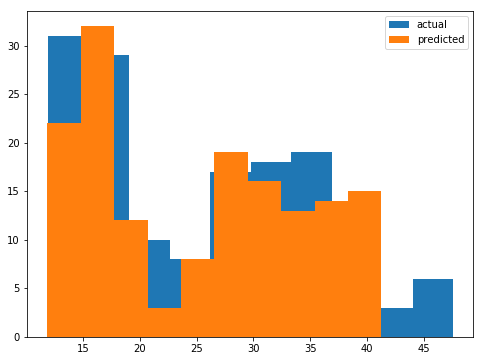

In [14]:
## KNN Regressor .
predictors = energy_data[['X1','X7']]
target = energy_data['Y2']
##

X_train, X_test, y_train, y_test = train_test_split(predictors, target, random_state = 1, test_size = 0.2)
print("\n X_train : {}".format(X_train.shape))
print("\n X_test : {}".format(X_test.shape))
print("\n y_train : {}".format(y_train.shape))
print("\n y_test : {}".format(y_test.shape))
knn = KNeighborsRegressor(n_neighbors = 10)
perform_reg(knn, X_train, X_test, y_train,y_test, 'knn')


In [33]:
## cross validate 
kf = KFold(n_splits = 5, random_state = 3, shuffle = True)
predictors = energy_data[['X1','X7']]
target = energy_data['Y2']
##
knn = KNeighborsRegressor(n_neighbors = 10)
cross_val_score(knn, predictors , target, cv = kf).mean()

0.95421468983100299

In [34]:
r2_y2['KNN'] = 0.954

In predicting cooling load, Decision Trees Regression, Random Forest and KNN have the same similar performance in prediction accuracy , X1 and X7 being the important variables.  
GBM gives the least RMSE.
The following graphs are concluding.  
Neural Nets can be be tried to further improve the RMSE.  

   

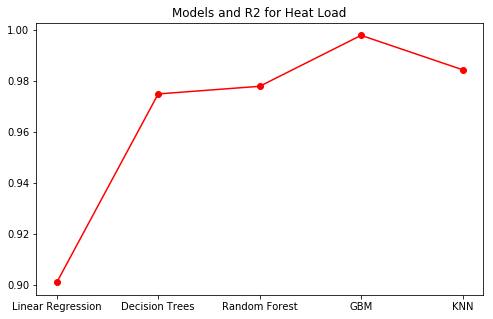

In [57]:
plt.figure(figsize = (8,5))
plt.plot(*zip(*r2_y1.items()),'-o', color = 'red')
plt.title('Models and R2 for Heat Load')
plt.show()

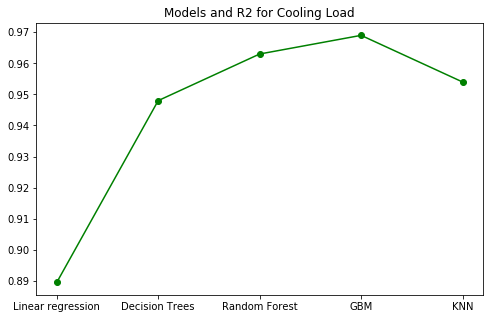

In [58]:
plt.figure(figsize = (8,5))
plt.plot(*zip(*r2_y2.items()),'-o', color = 'green')
plt.title('Models and R2 for Cooling Load')
plt.show()